In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pystan
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
dataRU = np.array(pd.read_csv('http://www.becs.aalto.fi/~smirnod1/RusKarina.csv',header=None))
dataENG = np.array(pd.read_csv('http://www.becs.aalto.fi/~smirnod1/EngKarina.csv',header=None))
print(dataRU.shape)
print(dataENG.shape)

data1 = np.zeros(np.shape(dataRU))
data2 = np.zeros(np.shape(dataENG))
data1[dataRU == 7] = 1
data1[dataRU == 1] = 1
data1[data1 == 0] = 0
data2[dataENG == 7] = 1
data2[dataENG == 1] = 1
data2[data2 == 0] = 0

S = dataRU.shape[1]
N1 = dataRU.shape[0]
N2 = dataENG.shape[0]
y1 = data1
y2 = data2

data = dict(y1=np.array(y1,dtype=int),y2=np.array(y2,dtype=int),S=S,N1=N1,N2=N2)

(327, 30)
(332, 30)


Here I used approach taken by John Krushcke (DBDA2 book, chapter 9.7). 

$$\kappa_g \sim \mathcal{Gamma}(\alpha=0.01,\beta=0.01)$$
$$\omega_g \sim \mathcal{Beta}(1,1)$$
$$\theta_{g,c} \sim \mathcal{Beta}(\omega_g(\kappa_g-2)+1), (1-\omega_g)(\kappa-2)+1)$$
$$y_{g,c} \sim \mathcal{Ber}(\theta_{g,c})$$

In [4]:
model = """
data {
    int<lower=1> S;
    int<lower=1> N1;
    int<lower=1> N2;
    int<lower=0,upper=1> y1[N1,S];
    int<lower=0,upper=1> y2[N2,S];
    }
parameters {
    real<lower=0,upper=1> theta1[S]; // individual prob correct
    real<lower=0,upper=1> omega1;    // group mode
    real<lower=0> kappaMinusTwo1;    // group concentration minus two

    real<lower=0,upper=1> theta2[S]; // individual prob correct
    real<lower=0,upper=1> omega2;    // group mode
    real<lower=0> kappaMinusTwo2;    // group concentration minus two
    }
transformed parameters {
    real<lower=0> kappa1;  
    real<lower=0> kappa2;  
    kappa1 <- kappaMinusTwo1 + 2;
    kappa2 <- kappaMinusTwo2 + 2;
    }
model {
    omega1 ~ beta(1,1);
    omega2 ~ beta(1,1);
    kappaMinusTwo1 ~ gamma(0.01,0.01);
    kappaMinusTwo2 ~ gamma(0.01,0.01);

    theta1 ~ beta(omega1*(kappa1-2)+1, (1-omega1)*(kappa1-2)+1); 
    theta2 ~ beta(omega2*(kappa2-2)+1, (1-omega2)*(kappa2-2)+1); 

    for (s in 1:S) {
        y1[s] ~ bernoulli(theta1[s]);
        y2[s] ~ bernoulli(theta2[s]);
        }
    }
    
"""  


In [5]:
fit = pystan.stan(model_code=model, data=data, iter=10000, chains=1, warmup=2000)

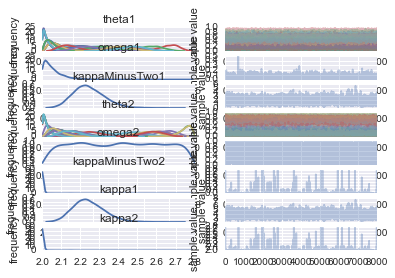

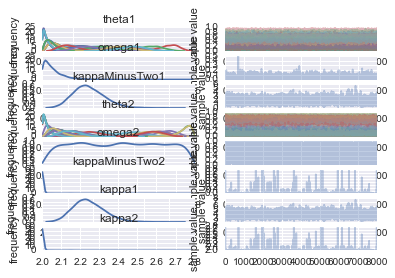

In [14]:
fit.plot()


In [ ]:
samples = fit.extract()